In [1]:
from collections import namedtuple

Определим основные сущности. Article - данный документ из коллекции. Document - документ с выделенным текстом для индексирования. Query - запрос.

In [2]:
Article = namedtuple('Article', ['id', 'title', 'authors', 'info', 'abstract'])
Query = namedtuple('Query', ['id', 'query_string'])
Document = namedtuple('Document', ['id', 'text'])

Считываем статьи. В некоторых документах виделись аномалии, поведение в этих редких ситуациях захардродим руками.

In [3]:
DOCS_COUNT = 1400

In [4]:
articles = list()
with open('data/cran.all.1400') as f:
    raw_text = f.read()
documents_data = raw_text.split('.I')[1:]
assert len(documents_data) == DOCS_COUNT
for (i, doc_data) in enumerate(documents_data):
    (doc_id, doc_data) = doc_data.split('.T')
    doc_id = int(doc_id.strip())
    if doc_id != 240:
        (title, doc_data) = doc_data.split('.A')
    else:
        (title, doc_data, _) = doc_data.split('.A')
    title = title.strip()
    (authors, doc_data) = doc_data.split('.B')
    authors = authors.strip()
    if doc_id not in (576, 578):
        (info, abstract) = doc_data.split('.W')
    else:
        (info, abstract, _) = doc_data.split('.W')
    info = info.strip()
    info = abstract.strip()
    articles.append(Article(
        id=doc_id,
        title=title,
        authors=authors,
        info=info,
        abstract=abstract,
    ))

Считываем запросы.

In [5]:
queries = list()

with open('data/cran.qry') as f:
    raw_text = f.read()
queries_data = raw_text.split('.I')[1:]
for (i, query_data) in enumerate(queries_data):
    query_data_splitted = query_data.split('.W')
    assert len(query_data_splitted) == 2
    queries.append(Query(id=i+1, query_string=query_data_splitted[1]))

Собственно, реализация поискового движка. У нас он строит индекс, используя tokenizer для пропроцессинга, ищет в нем, генерируя наборы признаков. Далее, основываясь на скоринге предоставляемом scorer-ом, делает ранжирование.

In [6]:
from collections import defaultdict
from collections import namedtuple
from itertools import chain

Features = namedtuple('Features', ['query_token_count', 'doc_token_count', 'token_df',
                                   'all_docs', 'doc_length', 'doc_length_avg',
                                   'relevant_documents_count', 'relevant_documents_with_token_count'])

def get_counts_dict(sequence):
    result = defaultdict(int)
    for el in sequence:
        result[el] += 1
    return result


class Search(object):
    def __init__(self, documents, tokenizer, scorer):
        self._tokenizer = tokenizer
        self._scorer = scorer
        self._documents = documents
        self._doc_length = dict()
        self._inverted_index = defaultdict(list)
        self._build_invert_index(documents)
        self._doc_length_avg = sum(self._doc_length.values()) / len(self._doc_length)

    def reset_scorer(self, scorer):
        self._scorer = scorer

    def _build_invert_index(self, documents):
        documents = sorted(documents, key=lambda x: x.id)
        for doc in documents:
            doc_tokens = self._tokenizer(doc.text)
            self._doc_length[doc.id] = len(doc_tokens)
            token_counts = get_counts_dict(doc_tokens)
            for token, count in token_counts.items():
                self._inverted_index[token].append((doc.id, count))

    def get_inverted_index(self):
        return self._inverted_index

    def search(self, query):
        query_tokens_counts = get_counts_dict(self._tokenizer(query))
        tokens_by_doc = defaultdict(list)
        relevant_documents_count = len(set(chain.from_iterable([el[0] for el in self._inverted_index.get(token, list())] for token in query_tokens_counts)))
        for token, token_count in query_tokens_counts.items():
            token_docs = self._inverted_index.get(token, list())
            for doc_id, doc_token_count in token_docs:
                tokens_by_doc[doc_id].append(Features(
                    query_token_count=token_count,
                    doc_token_count=doc_token_count,
                    token_df=len(token_docs),
                    all_docs=len(self._documents),
                    doc_length=self._doc_length[doc_id],
                    doc_length_avg=self._doc_length_avg,
                    relevant_documents_count=relevant_documents_count,
                    relevant_documents_with_token_count=len(token_docs),
                ))
        docs_scores = [(doc_id, self._scorer(doc_info)) for doc_id, doc_info in tokens_by_doc.items()]
        return [doc_id for doc_id, doc_score in sorted(docs_scores, key=lambda doc_id_score: doc_id_score[1], reverse=True)]

Собственно, реализация tokenizer-а и scorer-a. Токенайзер делает стемминг и удаление стопслов на основе nltk. Scorer вычисляет релевантность. В данной реализации мы предусмотрели альтернативную формулу для idf, дополнительный множитель для частот слов в запросе, а также возможность нормирования на сумму idf.

In [7]:
import string
import nltk
import random
import math

STOPWORDS = set(nltk.corpus.stopwords.words('english') + list(string.punctuation))

STEMMER = nltk.stem.porter.PorterStemmer()

class Tokenizer(object):
    def __call__(self, text):
        text = text.strip().replace('\n', ' ')
        tokens = [el.lower() for el in nltk.word_tokenize(text)]
        tokens = [STEMMER.stem(el) for el in tokens if el not in STOPWORDS]
        return tokens

class Scorer(object):
    def __init__(self, k1, k2, b, idf_is_bm25, norm_idf):
        self._k1 = k1
        self._k2 = k2
        self._b = b
        self._idf_is_bm25 = idf_is_bm25
        self._norm_idf = norm_idf

    def _idf_bm25(self, docs_count, token_docs_count):
        return math.log((docs_count - token_docs_count + 0.5) / (token_docs_count + 0.5))

    def _idf_with_relevant_docs(self, docs_count, token_docs_count, relevant_docs_count, relevant_docs_with_token_count):
        return math.log((relevant_docs_with_token_count + 0.5) / (relevant_docs_count - relevant_docs_with_token_count + 0.5) / (token_docs_count - relevant_docs_with_token_count + 0.5) * (docs_count - token_docs_count - relevant_docs_count + relevant_docs_with_token_count + 0.5))

    def _idf(self, features):
        if self._idf_is_bm25:
            return self._idf_bm25(docs_count=features.all_docs, token_docs_count=features.token_df)
        else:
            return self._idf_with_relevant_docs(
                docs_count=features.all_docs,
                token_docs_count=features.token_df,
                relevant_docs_count=features.relevant_documents_count,
                relevant_docs_with_token_count=features.relevant_documents_with_token_count,
            )

    def _token_score(self, features):
        return features.query_token_count * features.doc_token_count * (self._k1 + 1) / (features.doc_token_count + self._k1 * (1 - self._b + self._b * features.doc_length / features.doc_length_avg))

    def __call__(self, doc_data):
        ans = 0.0
        idf_sum = 0.0
        for features in doc_data:
            idf = self._idf(features)
            idf_sum += idf
            ans += idf * features.doc_token_count * (self._k1 + 1) / (features.doc_token_count + self._k1 * (1 - self._b + self._b * features.doc_length / features.doc_length_avg)) * (self._k2 + 1) * features.query_token_count / (self._k2 + features.query_token_count)
        if self._norm_idf:
            ans /= idf_sum
        return ans

Собственно, сущность, проверяющая качество движка. Основана на eval.py с той разницей, что возвращает метрики как объект и встроено в код. Также evaluator делает запросы в поисковый движок и отрезает выдочу до 10 элементов, чтобы сгенерировать пары запрос-документ.

In [8]:
import numpy as np


Metrics = namedtuple('Metrics', ['precision', 'recall', 'f_measure', 'MAP'])


class Evaluator(object):
    def __init__(self, answer_pairs_path, possible_queries):
        self._possible_queries = possible_queries
        self._true_pairs = list()
        with open(answer_pairs_path) as f:
            for line in f:
                qid, did = [int(x) for x in line.split()]
                self._true_pairs.append((qid, did))

    def _eval_predicted_pairs(self, predicted_pairs):
        q2reld = {}
        for qid, did in self._true_pairs:
            if qid in q2reld.keys():
                q2reld[qid].add(did)
            else:
                q2reld[qid] = set()

        q2retrd = {}
        for qid, did in predicted_pairs:
            if qid in q2retrd.keys():
                q2retrd[qid].append(did)
            else:
                q2retrd[qid] = []       

        N = len(q2retrd.keys())
        precision = sum([len(q2reld[q].intersection(q2retrd[q]))*1.0/len(q2retrd[q]) for q in q2retrd.keys()]) / N
        recall = sum([len(q2reld[q].intersection(q2retrd[q]))*1.0/len(q2reld[q]) for q in q2retrd.keys()]) / N
        f_measure = 2*precision*recall/(precision+recall)

        # MAP@10

        MAP = 0.0
        for q in q2retrd.keys():
            n_results = min(10, len(q2retrd[q]))
            avep = np.zeros(n_results)
            for i in range(n_results):
                avep[i:] += q2retrd[q][i] in q2reld[q]
                avep[i] *= (q2retrd[q][i] in q2reld[q]) / (i+1.0)
            MAP += sum(avep) / min(n_results, len(q2reld[q]))
        return Metrics(
            precision=precision,
            recall=recall,
            f_measure=f_measure,
            MAP=MAP/N,
        )

    def __call__(self, engine):
        query_result_pairs = list()
        for query in self._possible_queries:
            found_docs = engine.search(query.query_string)
            for doc_id in found_docs[:10]:
                query_result_pairs.append((query.id, doc_id))
        return self._eval_predicted_pairs(predicted_pairs=query_result_pairs)

In [9]:
evaluator = Evaluator(answer_pairs_path='data/qrel_clean', possible_queries=queries)

In [10]:
Params = namedtuple('Params', ['use_article', 'use_abstract', 'k1', 'k2', 'b', 'idf_is_bm25', 'norm_idf'])

Здесь у нас grid search разных параметров: use_article - использовать ли заголовок, use_abstract - использовать ли текст, k1, k2 (по логарифмической сетке), b, idf_is_bm25 - переключение между разными вариантами вычисления idf, norm_idf - нужно ли нормировать idf. Комбинаций параметров получилось достаточно много, поэтому используем следующие оптимизации:
        1) Разделели построение индекса и выполнение запросов. Так как на индекс влияют только первые два параметра, то вынесли их в начало и строим индекс только когда они изменяются. При этом скоринговую функицю устанавливаем только в момент определения остальных параметров.
        2) Делаем перебор в много процессов.

In [ ]:
import time
import sys
import pickle
import traceback
from concurrent.futures import ProcessPoolExecutor


def eval_search(evaluator, search, scorer):
    search.reset_scorer(scorer)
    return evaluator(search)

stdout = sys.stdout
sys.stdout = open('log', 'w')

trial_results = list()
start_time = time.time()
try:
    trial = 0
    for use_article, use_abstract in [(True, False), (False, True), (True, True)]:
            search = Search(
                documents=[
                    Document(
                        id=article.id, 
                        text=((article.title + ' ') if use_article else "") + 
                            (article.abstract if use_abstract else "")
                    ) for article in articles],
                tokenizer=Tokenizer(),
                scorer=None,
            )

            with ProcessPoolExecutor(max_workers=32) as e:
                futures = list()
                for k1 in [el / 10 for el in range(12, 21)]:
                    for k2 in [0] + [3 ** i for i in range(7)]:
                        for b in [el / 20 for el in range(21)]:
                            for idf_is_bm25 in [False, True]:
                                for norm_idf in [False, True]:
                                    trial += 1

                                    print(trial, time.time() - start_time, end=", ")
                                    sys.stdout.flush()
                                    future = e.submit(
                                        eval_search,
                                        evaluator=evaluator,
                                        search=search,
                                        scorer=Scorer(k1=k1, k2=k2, b=b, idf_is_bm25=idf_is_bm25, norm_idf=norm_idf),
                                    )
                                    futures.append((
                                        Params(
                                            use_article=use_article,
                                            use_abstract=use_abstract,
                                            k1=k1, k2=k2, b=b,
                                            idf_is_bm25=idf_is_bm25,
                                            norm_idf=norm_idf,
                                        ),
                                        future,
                                    ))

                trial_results.extend([(el[0], el[1].result()) for el in futures])
except:
    print(traceback.format_exc())
finally:
    sys.stdout = stdout

with open("trial_results.pkl", "wb") as f:
    pickle.dump(trial_results, f)

In [13]:
inverted_index = Search(
    documents=[
        Document(
            id=article.id, 
            text=article.abstract,
        ) for article in articles],
    tokenizer=Tokenizer(),
    scorer=None,
).get_inverted_index()

Посчитаем статистики по инвертированному индексу

In [14]:
print("dictionary size:", len(inverted_index))
print("min docs for token:", min(len(el) for el in inverted_index.values()))
print("max docs for token:", max(len(el) for el in inverted_index.values()))
print("average docs for token:", sum(len(el) for el in inverted_index.values()) / len(inverted_index))

dictionary size: 7004
min docs for token: 1
max docs for token: 713
average docs for token: 12.334094802969732


(array([  3.62000000e+03,   8.77000000e+02,   3.70000000e+02,
          2.47000000e+02,   1.89000000e+02,   1.19000000e+02,
          1.29000000e+02,   9.80000000e+01,   8.10000000e+01,
          7.40000000e+01,   4.80000000e+01,   6.60000000e+01,
          4.30000000e+01,   3.60000000e+01,   3.70000000e+01,
          4.90000000e+01,   3.20000000e+01,   3.10000000e+01,
          2.80000000e+01,   3.00000000e+01,   2.80000000e+01,
          2.00000000e+01,   2.60000000e+01,   1.30000000e+01,
          2.60000000e+01,   2.10000000e+01,   1.10000000e+01,
          1.60000000e+01,   1.80000000e+01,   1.50000000e+01,
          1.60000000e+01,   9.00000000e+00,   1.00000000e+01,
          1.30000000e+01,   1.20000000e+01,   1.70000000e+01,
          8.00000000e+00,   8.00000000e+00,   1.60000000e+01,
          1.60000000e+01,   1.70000000e+01,   6.00000000e+00,
          5.00000000e+00,   1.00000000e+01,   7.00000000e+00,
          7.00000000e+00,   4.00000000e+00,   6.00000000e+00,
        

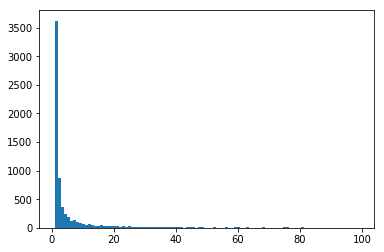

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist([len(el) for el in inverted_index.values() if len(el) < 100], bins=100)

По графику видно, что многие слова встречаются всего раз. Это говорит о том, что неплохо бы более агрессивно нормализовать слова: например, кластеризовать синонимы.

In [16]:
import pickle
with open("trial_results.pkl", "rb") as f:
    trial_results = pickle.load(f)

Построим гистограмму значений MAP для наших экспериментов. Видно, что есть много очень плохих результатов, а наилучшие результаты достагнуты в районе 0.22

(array([  1.75600000e+03,   2.74100000e+03,   1.55600000e+03,
          1.06500000e+03,   1.78900000e+03,   1.65000000e+02,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   4.20000000e+01,   1.52000000e+02,
          2.08000000e+02,   2.69000000e+02,   2.31000000e+02,
          4.55000000e+02,   4.08000000e+02,   8.33000000e+02,
          1.37100000e+03,   5.39000000e+02,   1.15000000e+02,
          1.34000000e+02,   1.79000000e+02,   4.67000000e+02,
          2.92000000e+02,   2.62000000e+02,   8.80000000e+01,
          1.00000000e+00,   2.40000000e+01,   3.80000000e+01,
          9.70000000e+01,   1.62000000e+02,   5.89000000e+02,
          6.18000000e+02,   4.29000000e+02,   3.91000000e+02,
        

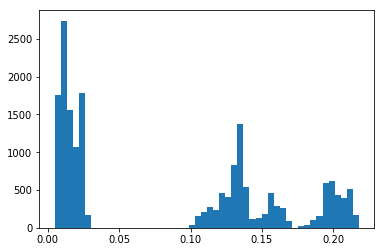

In [18]:
plt.hist([el[1].MAP for el in trial_results], bins=50)

Посмотрим, где достиглось наилучшее MAP. Видно, что для этого лучше всего использовать и название и текст статьи, k1=1.5, k2=1, b=0.7, а также надо испольовать обычный bm25 без нормализации на сумму idf.

In [19]:
max_MAP = max(el[1].MAP for el in trial_results)
max_MAP, [el[0] for el in trial_results if el[1].MAP == max_MAP]

(0.21798872861901972,
 [Params(use_article=True, use_abstract=True, k1=1.5, k2=1, b=0.7, idf_is_bm25=True, norm_idf=False)])

Посмотрим, где достигается максимальная точность. Видно, что во всех случаях используется и название и текст, а также b достаточно большое, то есть важно учитывать длину документа, также k1 = 1.7, b=0.5, k2 при этом более менее произвольный

In [21]:
max_precision = max(el[1].precision for el in trial_results)
max_precision, [el[0] for el in trial_results if el[1].precision == max_precision]

(0.217283950617284,
 [Params(use_article=True, use_abstract=True, k1=1.7, k2=9, b=0.5, idf_is_bm25=True, norm_idf=False),
  Params(use_article=True, use_abstract=True, k1=1.7, k2=81, b=0.5, idf_is_bm25=True, norm_idf=False),
  Params(use_article=True, use_abstract=True, k1=1.7, k2=243, b=0.5, idf_is_bm25=True, norm_idf=False),
  Params(use_article=True, use_abstract=True, k1=1.7, k2=729, b=0.5, idf_is_bm25=True, norm_idf=False)])

Видно, что максимальная полнота достигается при k1=1.6, k2=3, b=0.95, используется и текст и название документа.

In [23]:
max_recall = max(el[1].recall for el in trial_results)
max_recall, [el[0] for el in trial_results if el[1].recall == max_recall]

(0.3028956700429869,
 [Params(use_article=True, use_abstract=True, k1=1.6, k2=3, b=0.95, idf_is_bm25=True, norm_idf=False)])

С F-мерой ситуация аналогичная.

In [24]:
max_f_measure = max(el[1].f_measure for el in trial_results)
max_f_measure, [el[0] for el in trial_results if el[1].f_measure == max_f_measure]

(0.25203727774812434,
 [Params(use_article=True, use_abstract=True, k1=1.6, k2=3, b=0.95, idf_is_bm25=True, norm_idf=False)])

Посмотрим на влияние от использования названия, текста и и того и другого. Для этого построим гистограмму MAP для экспериментов с разными параметрами. Видно, что только название работает похуже, а использование и названия итекста работает примерно так же как и только текста.

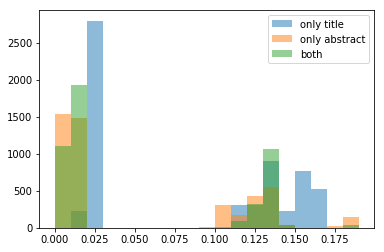

In [27]:
import numpy as np
bins = np.linspace(0.0, 0.19, 20)

plt.hist([el[1].MAP for el in trial_results if el[0].use_article == True and el[0].use_abstract == False], bins, alpha=0.5, label='only title')
plt.hist([el[1].MAP for el in trial_results if el[0].use_article == False and el[0].use_abstract == True], bins, alpha=0.5, label='only abstract')
plt.hist([el[1].MAP for el in trial_results if el[0].use_article == True and el[0].use_abstract == True], bins, alpha=0.5, label='both')
plt.legend(loc='upper right')
plt.show()

Также видно, что "обычный" bm25 работает лучше.

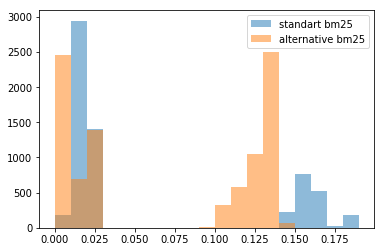

In [28]:
bins = np.linspace(0.0, 0.19, 20)

plt.hist([el[1].MAP for el in trial_results if el[0].idf_is_bm25 == True], bins, alpha=0.5, label='standart bm25')
plt.hist([el[1].MAP for el in trial_results if el[0].idf_is_bm25 == False], bins, alpha=0.5, label='alternative bm25')
plt.legend(loc='upper right')
plt.show()

Нормирование на сумму idf работает плохо. Это логично, так как если встретилось мало слов, становится не важно, редкими слова были или нет, что плохо сказывается на качестве.

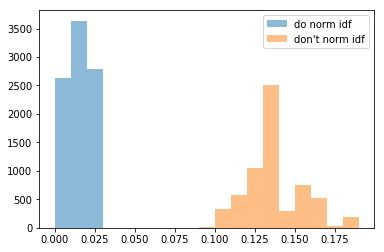

In [29]:
bins = np.linspace(0.0, 0.19, 20)

plt.hist([el[1].MAP for el in trial_results if el[0].norm_idf == True], bins, alpha=0.5, label='do norm idf')
plt.hist([el[1].MAP for el in trial_results if el[0].norm_idf == False], bins, alpha=0.5, label="don't norm idf")
plt.legend(loc='upper right')
plt.show()